Tutorial 2: Two Lens Galaxies
=============================

Up to now, all the images we've fitted had one lens galaxy. However, we saw in chapter 1 that our lens plane can
consist of multiple galaxies which each contribute to the strong lensing. Multi-galaxy systems are challenging to
model, because they add an extra 5-10 parameters to the `NonLinearSearch` and, more problematically, the degeneracies
between the `MassProfile`'s of the two galaxies can be severe.

However, we can still break their analysis down using a pipeline and give ourselves a shot at getting a good lens
model. Here, we're going to fit a double lens system, fitting as much about each individual lens galaxy before fitting
them simultaneously.

Up to now, I've put a focus on pipelines being general. The pipeline we write in this example is going to be the
opposite, specific to the image we're modeling. Fitting multiple lens galaxies is really difficult and writing a
pipeline that we can generalize to many lenses isn't currently possible with **PyAutoLens**.

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use new strong lensing data, where:

 - There are two lens galaxy's whose `LightProfile`'s are both `EllipticalSersic``..
 - There are two lens galaxy's whose `MassProfile`'s are both `EllipticalIsothermal``..
 - The source galaxy's `LightProfile` is an `EllipticalExponential`.

In [2]:
dataset_name = "light_sersic_x2__mass_sie_x2__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.05,
)

We need to choose our mask for the analysis. Given the lens light is present in the image we'll need to include all 
of its light in the central regions of the image, so lets use a circular mask.

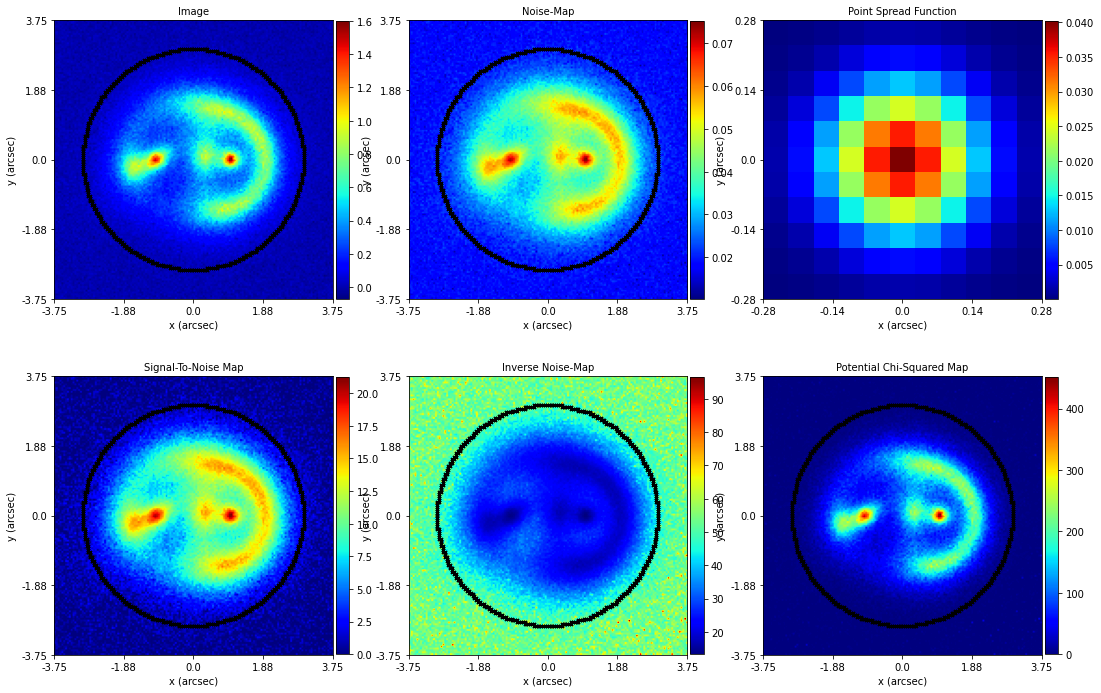

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Settings__

The `SettingsPhaseImaging` describe how the model is fitted to the data in the log likelihood function. We discussed
these in chapter 2, and a full description of all settings can be found in the example script:

 `autolens_workspace/notebooks/modeling/customize/settings.py`.

The settings chosen here are applied to all phases in the pipeline.

In [4]:
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2)

settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

__Pipeline Approach__

Looking at the image, there are clearly two blobs of light corresponding to our two lens galaxies. The source's 
light is also pretty complex - the arcs don't posses the rotational symmetry we're used to seeing up to now. 
Multi-galaxy ray-tracing is just a lot more complicated, which means so is modeling it!

So, how can we break the lens modeling up? As follows:

 1) Fit and subtract the light of each lens galaxy individually.
 2) Use these results to initialize each lens galaxy's total mass distribution.

So, with this in mind, we've written a pipeline composed of 4 phases:

 1) Fit the `LightProfile` of the lens galaxy on the left of the image, at coordinates (0.0", -1.0").
 2) Fit the `LightProfile` of the lens galaxy on the right of the image, at coordinates (0.0", 1.0").
 3) Use this lens-subtracted image to fit the source-`Galaxy`'s light. The `MassProfile`'s of the two lens 
 galaxies are fixed to (0.0", -1.0") and (0.0", 1.0").
 4) Fit all relevant parameters simultaneously, using priors from phases 1, 2 and 3.

__Pipeline Creation__

To create a `Pipeline`, we call a `make_pipeline` function, which is written in its own Python script: 

 `pipelines/tutorial_2_pipeline_x2_lens_galaxies.py`. 

Before we check it out, lets get the pipeline running, by importing the script, running the `make_pipeline` function
to create the `Pipeline` object and calling that objects `run` function.

In [5]:
from pipelines import tutorial_2_pipeline_x2_lens_galaxies

pipeline_x2_galaxies = tutorial_2_pipeline_x2_lens_galaxies.make_pipeline(
    path_prefix=path.join("howtolens", "c3_t2_x2_galaxies"),
    settings=settings,
    redshift_lens=0.5,
    redshift_source=1.0,
)

# Uncomment to run.
# pipeline_x2_galaxies.run(dataset=imaging, mask=mask)

Now, read through the `tutorial_2_pipeline_x2_galaxies.py` pipeline, to get a complete view of how it works. 
Once you`ve done that, come back here and we'll wrap up this tutorial.

And, we're done. This pipeline takes a while to run, as is the nature of multi-galaxy modeling. Nevertheless, 
the techniques we've learnt above can be applied to systems with even more `Galaxy`'s albeit the increases in 
parameters will slow down the non-linear search. Here are some more Q&A`s

 1) This system had two very similar lens galaxy's with comparable amounts of light and mass. How common is this? 
 Does it make it harder to model them?

Typically, a 2 galaxy system has 1 massive galaxy (that makes up some 80%-90% of the overall light and mass), 
accompanied by a smaller satellite. The satellite can`t be ignored - it impacts the ray-tracing in a measureable way, 
but its a lot less degenerate with the `main` lens galaxy. This means we can often model the  satellite with much 
simpler profiles (e.g. spherical profiles). So yes, multi-galaxy systems can often be easier to model.

 2) It got pretty confusing passing all those priors towards the end of the pipeline there, didn`t it?

It does get confusing, I won't lie. This is why we made galaxies named objects - so that we could call them the 
`left_lens` and `right_lens`. It still requires caution when writing the pipeline, but goes to show that if you name 
your galaxies sensibly you should be able to avoid errors, or spot them quickly when you make them.